### 状態について
大丈夫そう



### 行動について
大丈夫そう



### 報酬について
1. ~~毎ステップ、即時報酬に仮リターンを与える~~
2. ~~利確時にリターンを即時報酬を与える~~
3. ~~毎ステップ、即時報酬に仮リターンを与え、利確時にリターンを考慮した即時報酬を与える~~
4. シャープレシオ
99. 注文失敗時にマイナスの報酬を与える




### 学習について
#### ハイパら

#### バリデーション

- 過学習について
    - DoubleDQN
    

#### 効率化
- ステップサイズを変える
- カリキュラムラーニング（ステップサイズを徐々に大きくする）


#### モニタリングについて
- 累積報酬
    - train, eval
- リターン

In [1]:
import numpy as np
import pandas as pd
import gc
import warnings
import itertools
import feather
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from typing import *

import math
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

pd.options.display.max_rows = 200
pd.options.display.max_columns = 400

warnings.filterwarnings("ignore")

/root/.cache/pypoetry/virtualenvs/root-qv7zuvpL-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, inputs: int, outputs: int):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, outputs)

    def forward(self, x: torch.Tensor):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

### Market Data

In [4]:
rootdir = Path().resolve().parent
datadir = rootdir / "data" / "bybit" / "2022-07-24"
cachedir = rootdir / "data" / "cache"

In [5]:
dfs = list()
for i in range(1, 10):
    dfs.append(feather.read_dataframe(datadir / f"data_{i}.feather"))
df = pd.concat(dfs).reset_index(drop=True)
del dfs
gc.collect()

df = df[["open_time", "close", "high", "low"]].astype(float).astype(int)

df.columns = ["timestamp", "price", "max_price", "min_price"]
df[["buy_price", "sell_price"]] = df[["max_price", "min_price"]]

df.head()

,timestamp,price,max_price,min_price,buy_price,sell_price
0,1609426800,28490,28490,28339,28490,28339
1,1609427100,28569,28569,28490,28569,28490
2,1609427400,28622,28623,28539,28623,28539
3,1609427700,28559,28626,28532,28626,28532
4,1609428000,28598,28620,28559,28620,28559


In [6]:
def add_features(df):
    df["_diff"] = df["price"].diff()
    
    for minutes in [1, 2]:
        nm_dsharp, nm_p, nm_pcs, nm_area, nm_maxval, nm_minval, nm_maxlen, nm_minlen, nm_change = [
            f"{nm}_{minutes}" for nm in ["dsharp", "_p", "_pcs", "area", "maxval", "minval", "maxlen", "minlen", "change"]
        ]
        
        
        # 微分Sharp比
        df[nm_dsharp] = df["_diff"].rolling(minutes * 6).mean() / (df["_diff"].rolling(minutes * 6).std() + 1.0)

        df[nm_p] = find_cross_zero(x=df[nm_dsharp].values)
        df[nm_pcs] = df[nm_p].cumsum()

        _values = np.empty((df.shape[0], 4))
        for i, (price, ds, p, pcs) in enumerate(df[["price", nm_dsharp, nm_p, nm_pcs]].values):    
            sign = np.sign(ds)
            if pcs == 0:
                mt = {
                    nm_area: np.nan, nm_maxval: np.nan, nm_minval: np.nan,
                    nm_maxlen: np.nan, nm_minlen: np.nan,
                }
            else:
                if p:
                    mt = {
                        nm_area: 0, nm_maxval: -np.inf, nm_minval: np.inf,
                        nm_maxlen: 0, nm_minlen: 0,
                    }
                mt[nm_area] += sign * ds
                if ds > mt[nm_maxval]:
                    mt[nm_maxlen] = 0
                    mt[nm_maxval] = ds
                else:
                    mt[nm_maxlen] += 1
                if ds < mt[nm_minval]:
                    mt[nm_minlen] = 0
                    mt[nm_minval] = ds
                else:
                    mt[nm_minlen] += 1
            _values[i] = np.array([
                mt[nm_area],
                max(sign * mt[nm_maxval], sign * mt[nm_minval]),
                mt[nm_maxlen],
                mt[nm_minlen],
            ])
        df[[nm_area, nm_change, nm_maxlen, nm_minlen]] = _values
    
    df = df.dropna().reset_index(drop=True)
    return df


def find_cross_zero(x: np.ndarray) -> np.ndarray:
    x_len = x.shape[0] - 1
    y = np.zeros(x.shape[0]).astype(bool)
    for i in range(x.shape[0] - 1):
        if (x[x_len - i] > 0) and x[x_len - i - 1] <= 0:
            y[x_len - i] = True
        elif (x[x_len - i] < 0) and x[x_len - i - 1] >= 0:
            y[x_len - i] = True
        else:
            y[x_len - i] = False
    return y


def equal_divide_indice(length, num_divide):
    x = np.linspace(0, length - 1, length)
    indice = np.ones_like(x) * -1
    for i, thresh in enumerate(np.linspace(0, length, num_divide + 1)[:-1].astype(int)):
        indice[thresh : ] = i
    return indice


def divide_with_pcs(df, num_divide, division):
    df["_eq_fold"] = equal_divide_indice(length=df.shape[0], num_divide=num_divide)
    df["fold"] = np.nan
    for i, (start, end) in enumerate(df.groupby("_eq_fold")[division].agg(["min", "max"]).values):
        indice = (start < df[division]) & (df[division] <= end)
        df.loc[indice, "fold"] = i
    df["fold"] = df["fold"].fillna(method="ffill").fillna(method="bfill")
    return df

In [7]:
dfa = add_features(df=df)

features = ['dsharp_1', 'area_1','change_1', 'maxlen_1', 'minlen_1', 'dsharp_2', 'area_2', 'change_2', 'maxlen_2', 'minlen_2']
train = divide_with_pcs(df=dfa, num_divide=5, division="_pcs_2")
train = train[train.columns[~train.columns.str.startswith("_")]]

In [8]:
train.head(1)

,timestamp,price,max_price,min_price,buy_price,sell_price,dsharp_1,area_1,change_1,maxlen_1,minlen_1,dsharp_2,area_2,change_2,maxlen_2,minlen_2,fold
0,1609432500,28563,28705,28517,28705,28517,-0.445808,2.275032,0.534666,6.0,2.0,-0.292414,0.292414,0.292414,0.0,0.0,0.0


In [53]:
class Market(object):
    LOSSCUT_STEPS = np.inf # 1時間
    
    def __init__(self, df: pd.DataFrame, features: List[str]):
        self.market_states_cols = features
        self.market_states = df[self.market_states_cols].values
        self.prices = df[["price", "max_price", "min_price", "buy_price", "sell_price"]].values
        self.i = 0
        
        self.ob, self.os = False, False
        self.fb, self.fs = False, False
        self.lb, self.ls = None, None
        self.step_from_ob, self.step_from_os = 0, 0
        self.step_from_fb, self.step_from_fs = 0, 0
        
        self.sum_rtn = 0
        self.rtns = list()
        self.cur_rtn_sum = 0
        self.prices_when_fill = deque()
        self.position_side = None
    
    @property
    def num_steps(self) -> int:
        return self.prices.shape[0] - 2
        
    def step(self, action: str) -> float:
        market_state = self.market_states[self.i]
        price, bprice, sprice = self.prices[self.i, [0, 3, 4]]
        sthprice, bthprice = self.prices[self.i + 1, [1, 2]]
        
        if action == "Buy":
            if self.fb:
                pass
            else:
                if self.os:
                    self.unset_order_sell()
                self.set_order_buy(price=sprice)
        elif action == "Sell":
            if self.fs:
                pass
            else:
                if self.ob:
                    self.unset_order_buy()
                self.set_order_sell(price=bprice)
        elif action == "Hold":
            self.losscut_when_timeout(bprice=bprice, sprice=sprice)
        elif action == "Cancel":
            if self.ob:
                self.unset_order_buy()
            elif self.os:
                self.unset_order_sell()
            self.losscut_when_timeout(bprice=bprice, sprice=sprice)
        
        if self.ob:
            self.step_from_ob += 1
            if self.lb > bthprice:
                self.fb = True
                self.ob = False
                self.step_from_ob = 0
                self.position_side = "Buy"
        
        if self.os:
            self.step_from_os += 1
            if self.ls < sthprice:
                self.fs = True
                self.os = False
                self.step_from_os = 0
                self.position_side = "Sell"
        
        if self.fb:
            self.step_from_fb += 1
        
        if self.fs:
            self.step_from_fs += 1
            
        if (self.lb is not None) and (self.ls is not None):
            cur_rtn = self.ls / self.lb - 1
            self.append_sharp_ration_diff()
        elif self.lb is not None:
            cur_rtn = price / self.lb - 1
            self.append_sharp_ration_diff()
        elif self.ls is not None:
            cur_rtn = self.ls / price - 1
            self.append_sharp_ration_diff()
        else:
            cur_rtn = 0
        self.cur_rtn_sum += cur_rtn
        sharp_ratio = self.calc_sharp_ratio()
        
        if self.fb and self.fs:
            self.step_from_fb, self.step_from_fs = 0, 0
            rtn = self.ls / self.lb - 1
            self.fb, self.fs = False, False
            self.sum_rtn += rtn
            self.cur_rtn_sum = 0
            self.prices_when_fill = deque()
            self.position_side = None
        else:
            rtn = 0
        
        self.rtns.append({
            "i": self.i, "rtn": self.sum_rtn, "cur_rtn": cur_rtn,
            "ob": self.ob, "os": self.os, "fb": self.fb, "fs": self.fs,
            "act": action,
        })
        self.i += 1
        # return cur_rtn
        # return rtn
        # return cur_rtn / (max(self.step_from_fb, self.step_from_fs) + 1) + rtn
        return sharp_ratio
    
    def append_sharp_ration_diff(self):
        if len(self.prices_when_fill) == 0:
            self.prices_when_fill.append(0)
        else:
            if self.position_side == "Buy":
                self.prices_when_fill.append(self.prices[self.i, 0] / self.prices[self.i - 1, 0] - 1)
            elif self.position_side == "Sell":
                self.prices_when_fill.append(self.prices[self.i - 1, 0] / self.prices[self.i, 0] - 1)
    
    def calc_sharp_ratio(self) -> float:
        if len(self.prices_when_fill) > 2:
            rtn = np.mean(self.prices_when_fill)
            sigma = np.std(self.prices_when_fill)

            if sigma == 0:
                return 0
            else:
                return rtn / sigma - 1
        else:
            return 0
    
    def set_order_buy(self, price):
        self.ob = True
        self.lb = price
        self.step_from_ob = 0
    
    def set_order_sell(self, price):
        self.os = True
        self.ls = price
        self.step_from_os = 0
    
    def unset_order_buy(self):
        self.ob = False
        self.lb = None
        self.step_from_ob = 0
    
    def unset_order_sell(self):
        self.os = False
        self.ls = None
        self.step_from_os = 0
    
    def losscut_when_timeout(self, bprice: int, sprice: int) -> None:
        if self.fb and self.step_from_fb > self.LOSSCUT_STEPS:
            if self.os:
                self.unset_order_sell()
            self.set_order_sell(price=sprice) # すぐに約定する価格で注文
        elif self.fs and self.step_from_fs > self.LOSSCUT_STEPS:
            if self.ob:
                self.unset_order_buy()
            self.set_order_buy(price=bprice) # すぐに約定する価格で注文
        
    def state(self) -> np.ndarray:
        if (self.lb is not None) and (self.ls is not None):
            cur_rtn = self.ls / self.lb - 1
        elif self.lb is not None:
            cur_rtn = self.prices[self.i, 0] / self.lb - 1
        elif self.ls is not None:
            cur_rtn = self.ls / self.prices[self.i, 0] - 1
        else:
            cur_rtn = 0
        trade_state = np.array([
            int(self.ob), int(self.os), int(self.fb), int(self.fs), 
            cur_rtn,
            np.log1p(self.step_from_ob), np.log1p(self.step_from_os), np.log1p(self.step_from_fb), np.log1p(self.step_from_fs),
        ])
        market_state = self.market_states[self.i]
        return np.hstack([trade_state, market_state])
    
    def get_return(self) -> pd.DataFrame:
        return pd.DataFrame(self.rtns)
    

def random_market(df: pd.DataFrame, features: List[str], num_steps: int):
    idx = np.random.randint(df.shape[0] - 2 - num_steps)
    return Market(df=df.iloc[idx : idx + num_steps].reset_index(drop=True), features=features)

In [54]:
def plot(x: List[float], filepath: Path, xlabel: str = "", ylabel: str = ""):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.plot(x)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    fig.savefig(filepath)
    plt.close(fig)

### Training

In [55]:
dqn_params = {
    "BATCH_SIZE": 128,
    "GAMMA": 0.999,
    "EPS_START": 0.9,
    "EPS_END": 0.05,
    "EPS_DECAY": 200,
    "MEMORY_LENGTH": 10000,
}

TARGET_UPDATE = 10

In [56]:
actions = np.array(["Hold", "Buy", "Sell", "Cancel"])
n_actions = actions.shape[0]
state_dim = 9 + len(features)

In [57]:
class DQNAgent(object):
    PSEUDO_INF = 1e10
    
    def __init__(self, state_dim: int, n_actions: int, device: torch.device, params: Dict[str, Any]):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.device = device
        self.params = params
        
        self.policy_net = DQN(inputs=state_dim, outputs=n_actions).to(device)
        self.target_net = DQN(inputs=state_dim, outputs=n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = ReplayMemory(capacity=self.params["MEMORY_LENGTH"])
        
        self.steps_done = 0
        
        self.state_action_parser = StateActionParser(n_actions=n_actions)
    
    def select_action(self, state: torch.Tensor) -> torch.Tensor:
        sample = random.random()
        eps_threshold = self.params["EPS_END"] + (self.params["EPS_START"] - self.params["EPS_END"]) * math.exp(-1. * self.steps_done / self.params["EPS_DECAY"])
        self.steps_done += 1
        if sample > eps_threshold:
            return self.select_fixed_action(state=state)
        else:
            return self.select_feasible_action(logit=torch.from_numpy(np.random.rand(self.n_actions)).view(1, -1), state=state)
    
    def select_fixed_action(self, state: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            return self.select_feasible_action(logit=self.policy_net(state), state=state)
    
    def select_feasible_action(self, logit: torch.Tensor, state: torch.Tensor):
        infeasible_mask = self.state_action_parser.get_infeasible_action_mask(state=state)
        logit += -self.PSEUDO_INF * infeasible_mask
        return logit.max(1)[1].view(1, 1)
    
    def optimize_model(self) -> None:
        if len(self.memory) < self.params["BATCH_SIZE"]:
            return
        transitions = self.memory.sample(self.params["BATCH_SIZE"])
        batch = Transition(*zip(*transitions))
        
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)), 
            device=self.device, 
            dtype=torch.bool
        )
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(self.params["BATCH_SIZE"], device=self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.params["GAMMA"]) + reward_batch
        
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    def store_transition(self, transition: Tuple[torch.Tensor]) -> None:
        self.memory.push(*transition)
        
    def update_model(self) -> None:
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def save_model(self, filepath: Path) -> None:
        torch.save(self.policy_net.state_dict(), filepath)
        
        
class StateActionParser(object):
    CANT_BUY = [0, 1, 0, 0]
    CANT_BUY_CANCEL = [0, 1, 0, 1]
    CANT_SELL = [0, 0, 1, 0]
    CANT_SELL_CANCEL = [0, 0, 1, 1]
    CANT_CANCEL = [0, 0, 0, 1]
    
    def __init__(self, n_actions: int):
        self.n_actions = n_actions
    
    def get_infeasible_action_mask(self, state: torch.Tensor) -> torch.Tensor:
        order_buy, order_sell = state[0][0].item() == 1, state[0][1].item() == 1
        fill_buy, fill_sell = state[0][2].item() == 1, state[0][3].item() == 1
        if fill_buy and order_sell:
            return torch.tensor(self.CANT_BUY, dtype=torch.float32)
        elif fill_buy and (not order_sell):
            return torch.tensor(self.CANT_BUY_CANCEL, dtype=torch.float32)
        elif fill_sell and order_buy:
            return torch.tensor(self.CANT_SELL, dtype=torch.float32)
        elif fill_sell and (not order_buy):
            return torch.tensor(self.CANT_SELL_CANCEL, dtype=torch.float32)
        elif not (fill_buy or fill_sell or order_buy or order_sell):
            return torch.tensor(self.CANT_CANCEL, dtype=torch.float32)
        else:
            return torch.tensor(np.zeros(self.n_actions), dtype=torch.float32)

In [58]:
df_train, df_eval = train.loc[train["fold"] != 4].reset_index(drop=True), train.loc[train["fold"] == 4].reset_index(drop=True)
df_train.shape, df_eval.shape

((131196, 17), (32779, 17))

In [62]:
NUM_EPISODES = 1000
NUM_STEPS = 12 * 24 * 30 #1ヶ月

TRAIN_LOG_INTERVAL = 100
EVAL_LOG_INTERVAL = 100

savedir = cachedir / "task_4"
savedir.mkdir(exist_ok=True, parents=True)

In [63]:
agent = DQNAgent(state_dim=state_dim, n_actions=n_actions, device=device, params=dqn_params)

log = list()
best_reward = -np.inf
episode_durations = []
for i_episode in tqdm(range(NUM_EPISODES)):
    market = random_market(df=df_train, features=features, num_steps=NUM_STEPS)
    state = torch.tensor(market.state(), device=device, dtype=torch.float32).view(1, -1)
    
    rewards = list()
    for t in range(market.num_steps):
        action = agent.select_action(state=state)
        action_string = actions[action.item()]
        
        reward = market.step(action=action_string)
        rewards.append(reward)
        reward = torch.tensor([reward], device=device)

        next_state = torch.tensor(market.state(), device=device, dtype=torch.float32).view(1, -1)
        agent.store_transition((state, action, next_state, reward))
        agent.optimize_model()
        
        state = next_state
        
    
    episode_durations.append(np.mean(rewards))
    plot(x=episode_durations, filepath=savedir / "episode_durations.png", xlabel="episode", ylabel="avg reward")
    train_returns = market.get_return()["rtn"].values
    if (i_episode + 1) % TRAIN_LOG_INTERVAL == 0:
        plot(x=train_returns, filepath=savedir / f"train_returns_{i_episode + 1}.png", xlabel="steps", ylabel="return")
        plot(x=rewards, filepath=savedir / f"train_reward_{i_episode + 1}.png", xlabel="steps", ylabel="reward")
        market.get_return().to_csv(savedir / f"train_log_{i_episode + 1}.csv", index=False)
        agent.save_model(filepath=savedir / f"model_{i_episode + 1}.pt")

    if i_episode % TARGET_UPDATE == 0:
        agent.update_model()
        
    
    if (i_episode + 1) % EVAL_LOG_INTERVAL == 0:
        market = random_market(df=df_eval, features=features, num_steps=NUM_STEPS)
        state = torch.tensor(market.state(), device=device, dtype=torch.float32).view(1, -1)
        
        rewards = list()
        for t in range(market.num_steps):
            action = agent.select_fixed_action(state=state)
            action_string = actions[action.item()]

            reward = market.step(action=action_string)
            rewards.append(reward)

            next_state = torch.tensor(market.state(), device=device, dtype=torch.float32).view(1, -1)
            state = next_state
        
        eval_returns = market.get_return()["rtn"].values
        plot(x=eval_returns, filepath=savedir / f"eval_returns_{i_episode + 1}.png", xlabel="steps", ylabel="return")
        plot(x=rewards, filepath=savedir / f"eval_reward_{i_episode + 1}.png", xlabel="steps", ylabel="reward")
        market.get_return().to_csv(savedir / f"eval_log_{i_episode + 1}.csv", index=False)
        
        eval_reward = np.mean(rewards)
        if eval_reward > best_reward:
            plot(x=rewards, filepath=savedir / "eval_reward_best.png", xlabel="steps", ylabel="reward")
            plot(x=eval_returns, filepath=savedir / "eval_returns_best.png", xlabel="steps", ylabel="return")
            agent.save_model(filepath=savedir / "model_best.pt")
            best_reward = eval_reward
    else:
        eval_returns = [np.nan]
        eval_reward = np.nan
    
    log.append({
        "episode": i_episode + 1, "train_reward": episode_durations[-1], "train_return": train_returns[-1],
        "eval_reward": eval_reward, "eval_return": eval_returns[-1]
    })

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 613/1000 [6:55:46<4:22:29, 40.70s/it]


KeyboardInterrupt: 

In [53]:
agent.policy_net.load_state_dict(torch.load(cachedir / "task" / "model_best.pt"))

<All keys matched successfully>

In [54]:
market = random_market(df=df_eval, features=features, num_steps=NUM_STEPS)
state = torch.tensor(market.state(), device=device, dtype=torch.float32).view(1, -1)

rewards = list()
for t in range(market.num_steps):
    action = agent.select_action(state=state)
    action_string = actions[action.item()]

    reward = market.step(action=action_string)
    rewards.append(reward)

    next_state = torch.tensor(market.state(), device=device, dtype=torch.float32).view(1, -1)
    state = next_state

df_rtn = market.get_return()

In [55]:
prices = market.prices[1:-1, 0]

In [61]:
df_rtn["os"]

0       False
1       False
2       False
3       False
4       False
        ...  
8633    False
8634    False
8635     True
8636    False
8637    False
Name: os, Length: 8638, dtype: bool

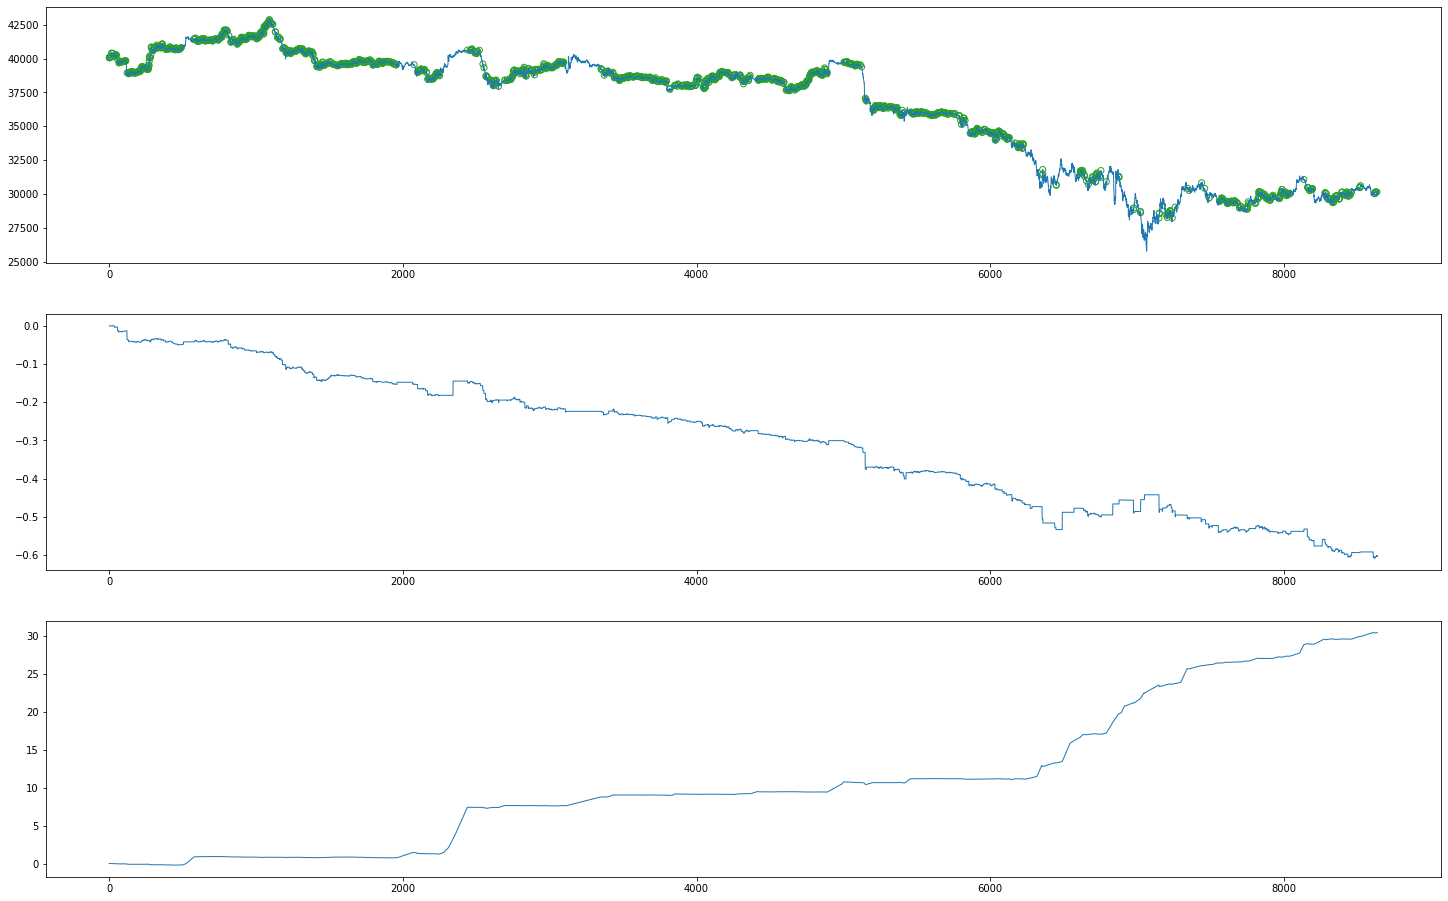

In [64]:
def point(ax, prices, indice, color, is_fill=True):
    if is_fill:
        ax.scatter(np.arange(prices.shape[0])[indice], prices[indice], color=color)
    else:
        ax.scatter(np.arange(prices.shape[0])[indice], prices[indice], facecolor='None', edgecolors=color)


fig, axes = plt.subplots(3, 1, figsize=(25, 16))

axes[0].plot(prices, lw=1)
point(axes[0], prices, df_rtn["ob"].values, "tab:green", False)
axes[1].plot(df_rtn["rtn"].values, lw=1)
axes[2].plot(df_rtn["cur_rtn"].cumsum().values, lw=1)